# License Plate Detection - Data Exploration and Preparation
This notebook explains the data collection used for the License Plate Detector model and prepares the data for training.

Main steps:
- Download data collection with labeled images of cars with German license plates
- Explore the data by displaying a selection
- Create a CSV file from the PASCAL VOC annotations, which is required for the generation of the TF-Record data set
- Generate TF-Record dataset used for model traning

The following diagram shows the directory structure that is created when executing the individual steps of this notebook:

```
<project_dir>
:   :   :
├── data
│   ├── plate_detection
│   │   ├── annotations
│   │   ├── images
│   │   │   ├── ger
│   │   │   │   ├── A-CR655.jpg
│   │   │   │   ├── A-MB1012.jpg
│   │   │   │   :
│   │   │   ├── other
│   │   │   :
│   │   ├── test_images
│   │   ├── train.record
│   │   ├── eval.record
│   │   ├── labels.csv
:   :   :     
```

Import common modules...

In [8]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import matplotlib
import requests

from google_drive_downloader import GoogleDriveDownloader as gdd
from matplotlib import pyplot as plt
from PIL import Image

Define variables for often used directories and files

In [9]:
# ****************** don't edit ******************
OUTPUT_DIR = 'data/plate_detection'
IMAGE_DIR = os.path.join(OUTPUT_DIR, 'images/ger')
ANNOTATIONS_DIR = os.path.join(OUTPUT_DIR, 'annotations')
LABELS_CSV = os.path.join(OUTPUT_DIR, 'labels.csv')

## Load and explore the Data
For the training of the License Plate Detector Models about 200 pictures of cars with German license plates were collected from the internet and labeled with the tool LabelImg. I.e. in each image the license plate was marked with a bounding box, which was assigned to the class "GER" (Germany). LabelImg saves the labels as annotations in PASCAL VOC format.

The dataset must first be downloaded from Google Drive into the local project directory...

In [10]:
gdd.download_file_from_google_drive(file_id='1qYkURFNtmveo4lmEMQfJ1M6HYtt60gNk',
                                    dest_path='data/plate_detection.zip',
                                    unzip=True)

Here is an example of the pictures from the data collection...

In [11]:
import glob
import matplotlib.image as mpimg

IMAGE_PATHS = []
IMAGE_NAMES = []
for filename in glob.glob(os.path.join(IMAGE_DIR, '*.jpg')):
    IMAGE_PATHS.append(mpimg.imread(filename))
    IMAGE_NAMES.append(filename.split('/')[-1])
    
print ('{} images found in {}'.format(len(IMAGE_PATHS), IMAGE_DIR))

211 images found in data/plate_detection\images/ger


In [12]:
# This is needed to display the images.
%matplotlib inline

def show_images(images, labels, figsize=(15, 5)):
    cols = 4
    rows = len(images) // cols

    image_index = 0
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            image = images[image_index]
            axarr[r, c].axis("off")
            axarr[r, c].title.set_text(labels[image_index])
            axarr[r, c].imshow(image, cmap='gray')
            image_index += 1

    plt.show()

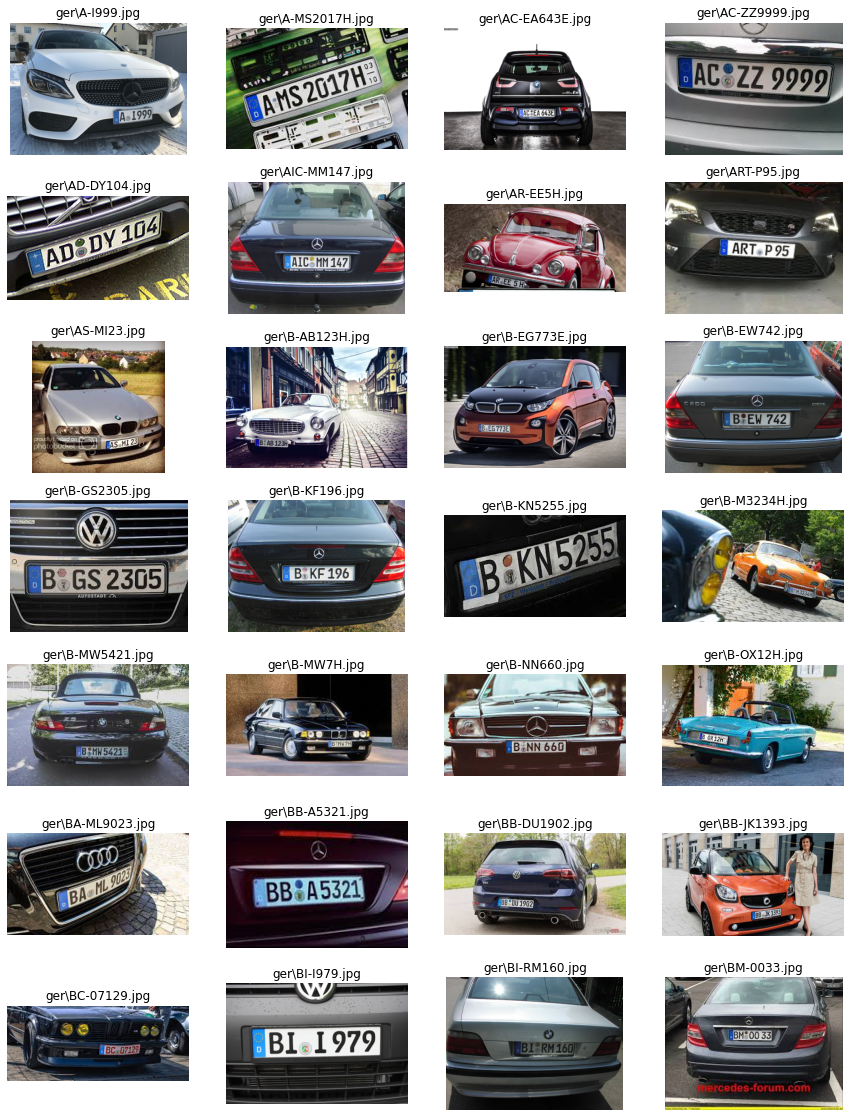

In [13]:
show_images(IMAGE_PATHS[:30], IMAGE_NAMES[:30], figsize=(15, 20))

### Create TF-Record dataset
The License Plate Detector Model will be created with the Tensorflow Object Detection API, which uses preferably data collections in TF-Record format. That means we have to convert the downloaded data collection from PASCAL VOC format to TF-Record format first.

In the first step we create a CVS file with the file paths of all images and the corresponding label information (class and bounding box)

In [14]:
!python utils/xml_to_csv.py -i {ANNOTATIONS_DIR} -o {LABELS_CSV}

Successfully converted xml to csv.


Using the generated CVS file, two data collections for the training (train.record) and for the evaluation (eval.record) are generated in TF-Record format. The parameter 'TRAIN_SIZE' is used to define the percentage used for the training data.

In [15]:
TRAIN_SIZE = 0.8 # use 80% of data as training data and the remaining 20% as evaluation data

!python utils/generate_tfrecord.py --train_size={TRAIN_SIZE} --csv_input={LABELS_CSV} --output_path={OUTPUT_DIR} --img_path={IMAGE_DIR}

211 images found
169 images stored in TFRecords: data/plate_detection\train.tfrecord
42 images stored in TFRecords: data/plate_detection\eval.tfrecord


2021-01-07 17:00:06.246666: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
